In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
G = 6.6726e-11   #Grav constant
dt=200  #timestep size
n= 121548  # based on theorteical transfer time 111802/5
i=0 #for the loop later
PI=np.pi

class Planet:
    def __init__(self, name, mass, dist, radius, period,theta):
        self.name=name
        self.mass=mass
        self.dist=dist
        self.radius=radius
        self.period=period
        self.theta=theta  #
        self.pos=self.dist*np.array([np.cos(2*PI*dt*i/self.period+theta),np.sin(2*PI*dt*i/self.period+theta)])
        self.vel=np.array([0.0,0.0])
        self.speed=np.linalg.norm(self.vel)
        #angular offset based on 28/07/2022   https://www.theplanetstoday.com/
        
class Satellite:
    def __init__(self, name, mass, pos):
        self.name=name
        self.mass=mass
        self.pos=pos
        self.vel=np.array([0,0])
        self.speed=np.linalg.norm(self.vel)


 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def toUnit(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def grav(pos, m1,m2,m3): #m1 is sun, m2 earth, m3 mars, m4 venus
    acc=np.array([0.0,0.0])
    r1=m1.pos-pos
    r2=m2.pos-pos
    r3=m3.pos-pos
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    magr3=np.linalg.norm(r3)
    r11=toUnit(r1)
    r21=toUnit(r2)
    r31=toUnit(r3)
    acc1_mag= G*m1.mass/(magr1*magr1)
    acc2_mag= G*m2.mass/(magr2*magr2)
    acc3_mag= G*m3.mass/(magr3*magr3)
    acc[0]= acc1_mag*r11[0]+acc2_mag*r21[0]+acc3_mag*r31[0]
    acc[1]= acc1_mag*r11[1]+acc2_mag*r21[1]+acc3_mag*r31[1]
    return acc

def RK4_nbody(fly,m1,m2,m3,a):  #up to 4 bodies
    z1=fly.pos+(a/2)*fly.vel
    acc1=grav(fly.pos,m1,m2,m3) #need fly but with position z1
    v1=fly.vel+(a/2)*acc1
    z2=fly.pos+(a/2)*v1
    acc2=grav(z1,m1,m2,m3)   #need fly but with position z2
    v2=fly.vel+(a/2)*acc2
    z3=fly.pos+a*v2
    acc3=grav(z2,m1,m2,m3)
    v3=fly.vel+a*acc3
    fly.pos=fly.pos+(a/6)*(fly.vel+2*v1+2*v2+v3)
    acc4=grav(z3,m1,m2,m3)
    fly.vel= fly.vel+(a/6)*(acc1+2*acc2+2*acc3+acc4)
    
    
    
def objective(V):  #fixed dt=200 and starting positions of planets
    earth = Planet("earth", 5.972e+24, 147136301904.61224,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
    mars = Planet("mars",6.39e+23, 245913469863.12405, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
    sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)


    earth.speed= 30278.263239783308 
    mars.speed= 22230.17728717589
    E_S_M= 42.589993497459346*PI/180
    mars_angle=1.59639117396732  #angle between velocity and position vectors
    earth_angle=1.5679385733198765
    marsvelangle= mars_angle-E_S_M    #angle velocity of mars makes with the horizontal
    earth.pos=np.array([earth.dist,0.0])
    earth.vel=np.array([earth.speed*np.cos(PI-earth_angle),earth.speed*np.sin(PI-earth_angle)])
    mars.pos=mars.dist*np.array([np.cos(E_S_M), np.sin(E_S_M)])
    mars.vel= mars.speed*np.array([-np.cos(marsvelangle), np.sin(marsvelangle)])

    rocket = Satellite("rocket", 2.8e+6,[0,0])
    rocket.pos=earth.pos+np.array([earth.radius,0.0])
    rocket.vel=earth.vel+np.array([0.0,(earth.radius/86400)*2*PI ])

    #input vector delat V, the additional velocity
    rocket.vel = rocket.vel+V
    for i in range(0,n):
        RK4_nbody(earth,sun,mars,rocket,dt)
        RK4_nbody(mars,sun,rocket,earth,dt)
        RK4_nbody(rocket,sun,earth,mars,dt) #200 is dt
    return np.linalg.norm(rocket.pos-mars.pos)  #works!
    
def minimizer(fun, xbounds, ybounds, nsteps):   #works
    xstep=(xbounds[1]-xbounds[0])/nsteps
    ystep=(ybounds[1]-ybounds[0])/nsteps
    best=10e+12
    minv=np.array([0.0,0.0])
    v=np.array([0.0,0.0])
    for i in range(0,nsteps):
        v[0]=i*xstep+xbounds[0]
        for k in range (0,nsteps):
            v[1]=k*ystep+ybounds[0]
            value= fun(v)
            print(v,value)
            if value<best:
                minv[0]=v[0]
                minv[1]=v[1]
                best=value
    print(minv, best)
    
def epsilon(POS,SPEED,m1,m2): #m1,m2,m3,m4 are sun,earth,mars,venus, k is i (which element of array pointer)
    EK=0.5*SPEED**2
    r1=m1.pos-POS
    r2=m2.pos-POS
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    ham=EK-G*((m1.mass/magr1)+(m2.mass/magr2))
    return ham

earth = Planet("earth", 5.972e+24, 147136301904.61224,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
mars = Planet("mars",6.39e+23 , 245913469863.12405, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)


earth.speed= 30278.263239783308 
mars.speed= 22230.17728717589
E_S_M= 42.589993497459346*PI/180
mars_angle=1.59639117396732  #angle between velocity and position vectors
earth_angle=1.5679385733198765
marsvelangle= mars_angle-E_S_M    #angle velocity of mars makes with the horizontal
earth.pos=np.array([earth.dist,0.0])
earth.vel=np.array([earth.speed*np.cos(PI-earth_angle),earth.speed*np.sin(PI-earth_angle)])
mars.pos=mars.dist*np.array([np.cos(E_S_M), np.sin(E_S_M)])
mars.vel= mars.speed*np.array([-np.cos(marsvelangle), np.sin(marsvelangle)])

rocket = Satellite("rocket", 2.8e+6,[0,0])
rocket.pos=earth.pos+np.array([earth.radius,0.0])
rocket.vel=earth.vel+np.array([0,(earth.radius/86400)*2*PI ])

[  -86.52769422 30741.45179664]
[  -86.52769422 30278.13960229]
landed successfully 121547


(-250000000000.0, 250000000000.0)

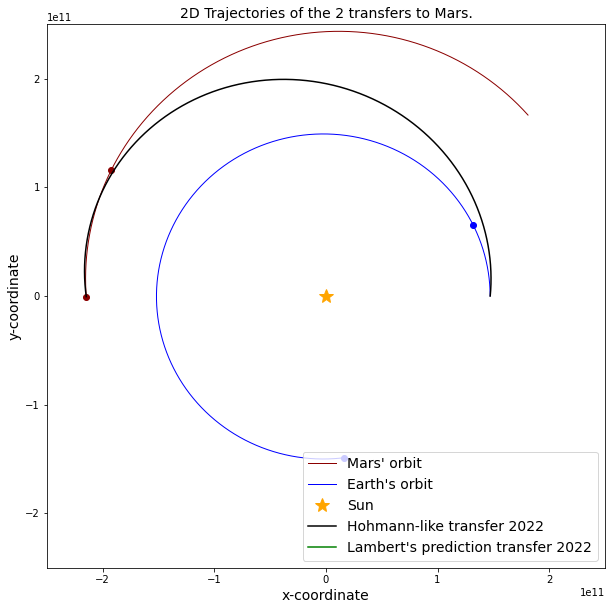

In [22]:
earth = Planet("earth", 5.972e+24, 147136301904.61224,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
mars = Planet("mars",6.39e+23, 245913469863.12405, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)


earth.speed= 30278.263239783308 
mars.speed= 22230.17728717589
E_S_M= 42.589993497459346*PI/180
mars_angle=1.59639117396732  #angle between velocity and position vectors
earth_angle=1.5679385733198765
marsvelangle= mars_angle-E_S_M    #angle velocity of mars makes with the horizontal
earth.pos=np.array([earth.dist,0.0])
earth.vel=np.array([earth.speed*np.cos(PI-earth_angle),earth.speed*np.sin(PI-earth_angle)])
mars.pos=mars.dist*np.array([np.cos(E_S_M), np.sin(E_S_M)])
mars.vel= mars.speed*np.array([-np.cos(marsvelangle), np.sin(marsvelangle)])

rocket = Satellite("rocket", 2.8e+6,[0,0])
rocket.pos=earth.pos+np.array([earth.radius,0.0])
rocket.vel=earth.vel+np.array([0,(earth.radius/86400)*2*PI ])
print(rocket.vel)
print(earth.vel)



PEX=np.zeros(n)
PEY=np.zeros(n)
PMX=np.zeros(n)
PMY=np.zeros(n)
RX=np.zeros(n)
RY=np.zeros(n)
#input vector delat V, the additional velocity   escape velocity 11110
V=np.array([10577.44748317,  2947.46702147] )  #[10480, 3130] [10485, 3090]    #[10490,3080]
rocket.vel = rocket.vel+V


for i in range(0,n):
    
    RK4_nbody(earth,sun,rocket,mars,dt)
    RK4_nbody(mars,sun,earth,rocket,dt)
    RK4_nbody(rocket,sun,earth,mars,dt)
    RX[i]=rocket.pos[0]
    RY[i]=rocket.pos[1]
    PEX[i]=earth.pos[0]
    PEY[i]=earth.pos[1]
    PMX[i]=mars.pos[0]
    PMY[i]=mars.pos[1]
    if np.linalg.norm(earth.pos-rocket.pos)<earth.radius:
        print("launch crash")
        break
    if np.linalg.norm(mars.pos-rocket.pos)<mars.radius:
        print("landed successfully", i)
        break
    


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(PMX,PMY, color="darkred", linewidth=1, label="Mars' orbit") #, ) marker="o",s=80)
ax.plot(PEX,PEY, color="blue", linewidth=1, label="Earth's orbit" )# , marker="o",s=80)
ax.plot(0,0,label='Sun', marker="*", markersize=15, color="orange", linewidth=0)
ax.scatter(PMX[i],PMY[i] ,color="darkred")
ax.scatter(PEX[i],PEY[i], color="blue")
#ax.sctter(PEX[], PEY[], color="green")
ax.scatter(PEX[11230],PEY[11230], color= "blue")
ax.scatter(PMX[11230+86391], PMY[11230+86391], color="darkred")
ax.plot(RX,RY, label='Hohmann-like transfer 2022',color="black" )
ax.plot(PEX[11230],PEY[11230], color="green", label="Lambert's prediction transfer 2022" ) #11230 is seconds after hohmann that lambert starts
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_title("2D Trajectories of the 2 transfers to Mars.",fontsize=14)
ax.legend(loc="lower right",fontsize=14)
plt.ylim([-2.5e+11, 2.5e+11])
plt.xlim([-2.5e+11,2.5e+11])

In [23]:
print(np.linalg.norm(mars.pos-rocket.pos))    #[10480  3052] 10050567801
                                              #[10490, 3080]  6287218724
                                            #  [10535,  3053] 1722606694
                                            # [10535, 3050]   1504286388
                                            # [10535, 5045]   1170180157
                                            # [10535, 5040]   909131044
                                            # [10535, 5030]   890941763
                                            # [10532  3038]   881144682.
                                            #[10541  3022]    694835369
                                            #[10541  3022]     694835369.
                                            #[10542.6  3020. ] 664736717
                                            #[10557.95  2987.4 ] 344756044
                                            #[10558.11093716,  2987.5 ] 343748708.53970766

2715986.0849819356


In [18]:

print("dv1=",np.linalg.norm(V))
print("dv2=",np.linalg.norm(mars.vel-rocket.vel))
print(np.linalg.norm(rocket.vel))
print('dvtot=', np.linalg.norm(V)+np.linalg.norm(mars.vel-rocket.vel))

dv1= 10980.435196378721
dv2= 6792.732465676917
18753.636894704363
dvtot= 17773.16766205564


In [20]:
print(mars.vel)
print(rocket.vel)

[  1885.75197712 -25440.57814534]
[   788.49605038 -18737.05341715]


In [50]:
import numpy as np

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.util import time_range

ModuleNotFoundError: No module named 'poliastro'

In [286]:
xbounds=[10557.90,10558.90]
ybounds=[2986.8, 2987.8]   #[10557.95  2987.4 ] 344756044
minimizer(objective, xbounds, ybounds, 10)

[10557.9  2986.8] 350550254.8373816
[10557.9  2986.9] 349260842.59343904
[10557.9  2987. ] 348164368.1974788
[10557.9  2987.1] 347262636.33093184
[10557.9  2987.2] 346557143.78506047
[10557.9  2987.3] 346049065.20005727
[10557.9  2987.4] 345739248.30525273
[10557.9  2987.5] 345628200.77864325
[10557.9  2987.6] 345716090.80626714
[10557.9  2987.7] 346002741.84534186
[10558.   2986.8] 346396554.92819154
[10558.   2986.9] 345497532.0876703
[10558.  2987.] 344795742.79733264
[10558.   2987.1] 344292369.7959142
[10558.   2987.2] 343988258.55898356
[10558.   2987.3] 343883913.7060461
[10558.   2987.4] 343979491.90558964
[10558.   2987.5] 344274802.5897922
[10558.   2987.6] 344769307.93778026
[10558.   2987.7] 345462128.6783343
[10558.1  2986.8] 343034259.86339086
[10558.1  2986.9] 342535643.3324912
[10558.1  2987. ] 342237300.6021998
[10558.1  2987.1] 342139730.0898012
[10558.1  2987.2] 342243079.13986874
[10558.1  2987.3] 342547140.18634707
[10558.1  2987.4] 343051355.4820857
[10558.1  2987

KeyboardInterrupt: 

In [ ]:
#[10548.  3010.]  553341702
#[10556.  2992.] 382279632
#[10557.  2990.] 365462180
#[10558.1  2987.4] 343051355.4

In [3]:
XBOUNDS=[10500,10600.0]   #[10558.1  2987.6] 344656288
YBOUNDS=[2900.0,2980.0]
V=np.array([10558.1,  2987.6])
bnds=(XBOUNDS,YBOUNDS)
minimize(objective, V, bounds=bnds)  #[10558.11093716,  2987.5       ]  [10561.75659711,  2980.        ]

      fun: 476019.6821492618
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-11540646.17533649,  27179107.18108231])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1686
      nit: 160
     njev: 562
   status: 2
  success: False
        x: array([10577.44748317,  2947.46702147])

In [ ]:
dt=200
dv1= 10980.435196378721
dv2= 6792.732465676917
18753.636894704363
dvtot= 17773.16766205564